# Tomato Disease Classification with ResNet152V2 and Neural Network

# Import Libraries

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

from PIL import Image

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score 
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Load Data

**Citation** 
<br />
Huang, Mei-Ling; Chang, Ya-Han (2020), “Dataset of Tomato Leaves”, Mendeley Data, 
<br />
V1, doi: 10.17632/ngdgg79rzb.1

In [3]:
print(os.getcwd())  # Prints the current working directory


/Users/krish/Thesis


In [4]:


TRAINING_DIR = os.path.join('/Users/krish/Thesis/data2/train')
VALIDATION_DIR = os.path.join('/Users/krish/Thesis/data2/val')
TESTING_DIR = os.path.join('/Users/krish/Thesis/data2/test')


In [5]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

In [6]:
train_dataset = tf.keras.utils.image_dataset_from_directory(TRAINING_DIR,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 8716 files belonging to 10 classes.


In [7]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(VALIDATION_DIR,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 2902 files belonging to 10 classes.


In [8]:
test_dataset = tf.keras.utils.image_dataset_from_directory(TESTING_DIR,
                                                           shuffle=False,
                                                           labels='inferred',
                                                           label_mode='categorical',
                                                           image_size=IMG_SIZE)

Found 2914 files belonging to 10 classes.


In [9]:
class_names = train_dataset.class_names
class_names

['Bacterial_spot',
 'Early_blight',
 'Healthy',
 'Late_blight',
 'Leaf_Mold',
 'Septoria_leaf_spot',
 'Target_Spot',
 'Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato_mosaic_virus',
 'Two_spotted_spider_mite']

# Visualize Training Data for each Class

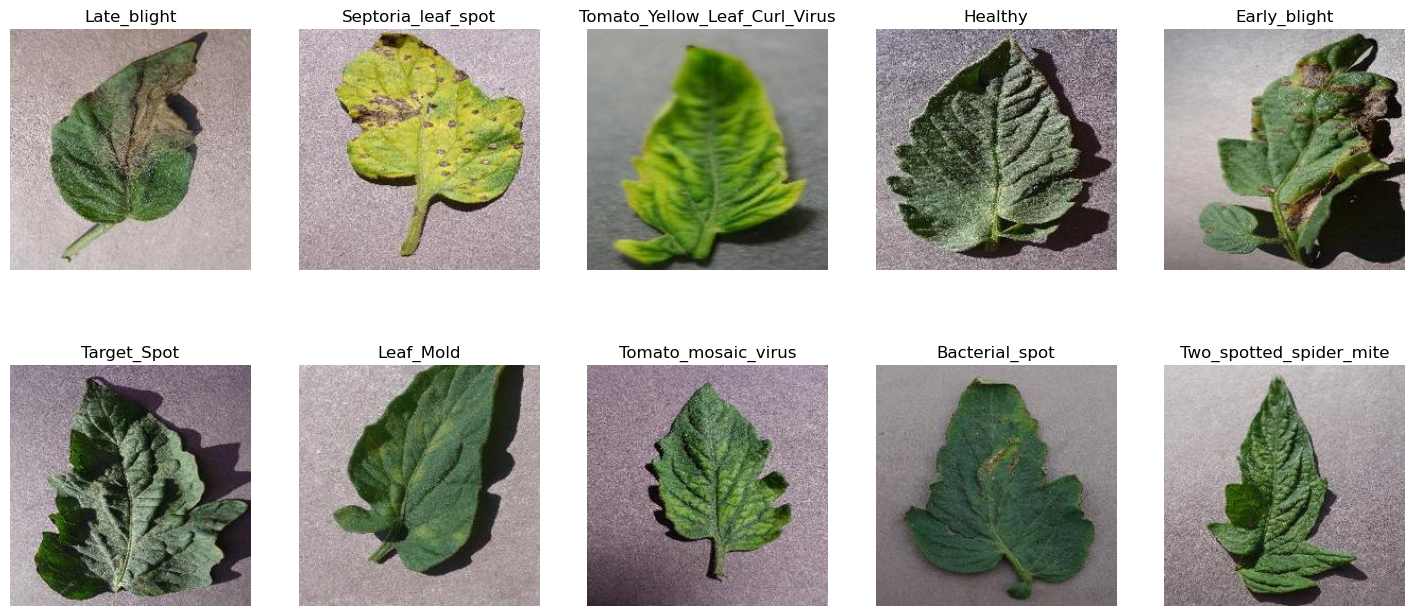

In [10]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import math

# List only directories (ignoring files like .DS_Store)
classes = [d for d in os.listdir('/Users/krish/Thesis/data2/train') if os.path.isdir(os.path.join('/Users/krish/Thesis/data2/train', d))]

# Determine the number of rows and columns needed for the subplots
num_classes = len(classes)
num_cols = 5
num_rows = math.ceil(num_classes / num_cols)

plt.figure(figsize=(18, 8))

for idx, class_name in enumerate(classes):
    pic = os.listdir('/Users/krish/Thesis/data2/train/' + class_name)[0]
    image = Image.open('/Users/krish/Thesis/data2/train/' + class_name + '/' + pic)
    image = np.asarray(image)
    plt.subplot(num_rows, num_cols, idx + 1)
    plt.title(class_name)
    plt.imshow(image)
    plt.axis("off")

plt.show()



# Data Summary

In [11]:
import os
import pandas as pd

categories = []
train = []
val = []
test = []

# Function to list directories only
def list_dirs(path):
    return [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]

# Read the categories and counts from the train directory
folders = list_dirs('/Users/krish/Thesis/data2/train')
for f in folders:
    categories.append(f)
    train.append(len(os.listdir(os.path.join('/Users/krish/Thesis/data2/train', f))))

# Read the counts from the validation directory
folders = list_dirs('/Users/krish/Thesis/data2/val')
for f in folders:
    val.append(len(os.listdir(os.path.join('/Users/krish/Thesis/data2/val', f))))

# Read the counts from the test directory
folders = list_dirs('/Users/krish/Thesis/data2/test')
for f in folders:
    test.append(len(os.listdir(os.path.join('/Users/krish/Thesis/data2/test', f))))

# Create a DataFrame with the counts
data_count = pd.DataFrame({'categories': categories,
                           'train': train,
                           'val': val,
                           'test': test                     
                          })

data_count



,categories,train,val,test
0,Late_blight,916,305,307
1,Septoria_leaf_spot,850,283,284
2,Tomato_Yellow_Leaf_Curl_Virus,2571,857,858
3,Healthy,764,254,255
4,Early_blight,480,160,160
5,Target_Spot,674,224,226
6,Leaf_Mold,457,152,153
7,Tomato_mosaic_virus,179,59,61
8,Bacterial_spot,1021,340,341
9,Two_spotted_spider_mite,804,268,269


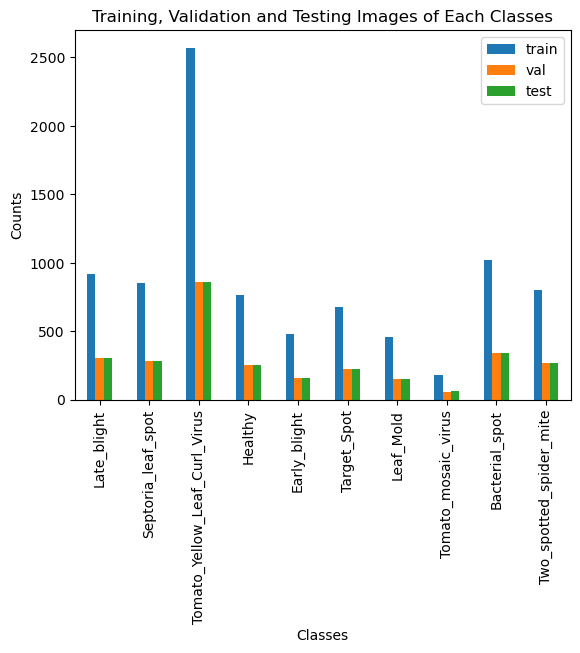

In [12]:
data_count.plot.bar(x='categories', title="Training, Validation and Testing Images of Each Classes")
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.show()

In [13]:
# Configure the dataset for performance
# Use buffered prefetching to load images from disk without having I/O become blocking.

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Data Augmentation

In [14]:
def data_augmentation(x):
    return tf.keras.Sequential([
        tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomContrast(factor=0.2),
    ])(x)

2024-08-23 07:45:45.163881: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


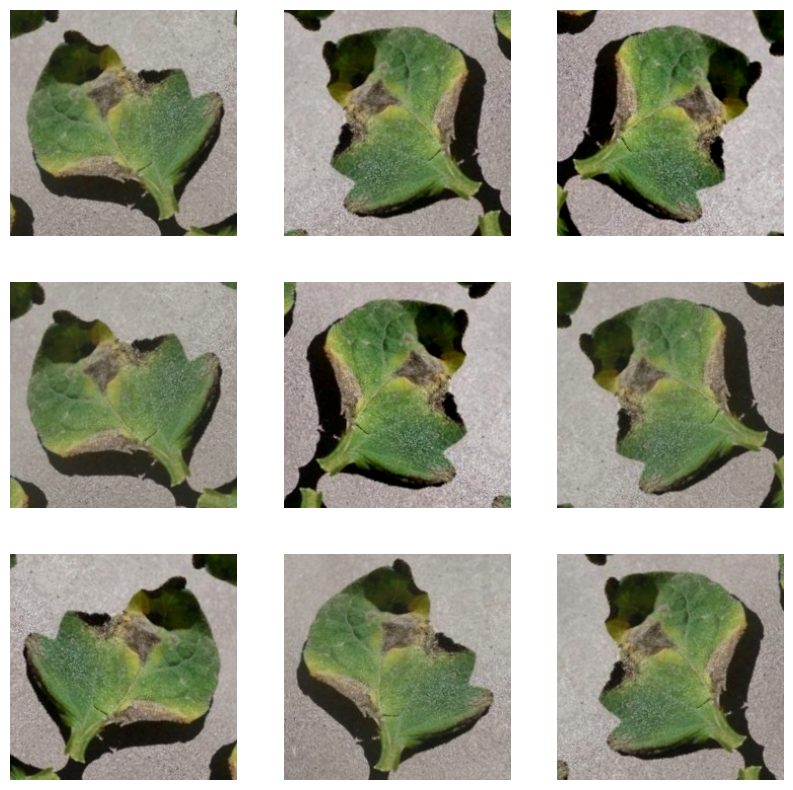

In [15]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

# Feature Extractor Base

In [16]:
IMG_SHAPE = IMG_SIZE + (3,)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [17]:
base_model.trainable = False

base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_9[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

# Utility Functions

In [18]:
def preprocess_input(x): 
    return tf.keras.layers.Rescaling(1./255, offset=-1)(x)


def feature_extractor(x):
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Flatten()(x)
    return x


def classifier(x):
    x = tf.keras.layers.Dense(264, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(264, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    return x


def prediction_layer(x):
    return tf.keras.layers.Dense(10, activation='softmax')(x)

# Add Classification Head

In [19]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = feature_extractor(x)
x = classifier(x)

outputs = prediction_layer(x)

model = tf.keras.Model(inputs, outputs)

# Compile the Model

In [20]:
base_learning_rate = 0.0001

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_9 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 264)            │       338,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 264)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 264)            │        69,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 264)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        16,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,683,738 (10.24 MB)

 Trainable params: 425,754 (1.62 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

# Add CSV Logger

In [22]:
import os

train_dir = '/Users/krish/Thesis/data2/train'
for root, dirs, files in os.walk(train_dir):
    print(root, "contains", len(files), "files")


/Users/krish/Thesis/data2/train contains 1 files
/Users/krish/Thesis/data2/train/Late_blight contains 916 files
/Users/krish/Thesis/data2/train/Septoria_leaf_spot contains 850 files
/Users/krish/Thesis/data2/train/Tomato_Yellow_Leaf_Curl_Virus contains 2571 files
/Users/krish/Thesis/data2/train/Healthy contains 763 files
/Users/krish/Thesis/data2/train/Healthy/.ipynb_checkpoints contains 1 files
/Users/krish/Thesis/data2/train/Early_blight contains 480 files
/Users/krish/Thesis/data2/train/Target_Spot contains 674 files
/Users/krish/Thesis/data2/train/Leaf_Mold contains 457 files
/Users/krish/Thesis/data2/train/Tomato_mosaic_virus contains 179 files
/Users/krish/Thesis/data2/train/Bacterial_spot contains 1021 files
/Users/krish/Thesis/data2/train/Two_spotted_spider_mite contains 804 files


In [23]:
# Verify the current working directory
print("Current Working Directory:", os.getcwd())

Current Working Directory: /Users/krish/Thesis


In [24]:
os.chdir("/Users/krish/Thesis/working/inception")

log_csv = CSVLogger('./mobileNetV2_NN_logs1.csv', separator=',', append=False)

In [25]:
initial_epochs = 10

In [26]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks=[log_csv])

Epoch 1/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 81s 292ms/step - accuracy: 0.3719 - loss: 1.8403 - val_accuracy: 0.6954 - val_loss: 0.9962
Epoch 2/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 80s 292ms/step - accuracy: 0.6476 - loss: 1.0707 - val_accuracy: 0.7746 - val_loss: 0.6969
Epoch 3/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 80s 293ms/step - accuracy: 0.7255 - loss: 0.8245 - val_accuracy: 0.8084 - val_loss: 0.5833
Epoch 4/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 79s 289ms/step - accuracy: 0.7592 - loss: 0.7108 - val_accuracy: 0.8208 - val_loss: 0.5339
Epoch 5/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 83s 304ms/step - accuracy: 0.7765 - loss: 0.6511 - val_accuracy: 0.8384 - val_loss: 0.4826
Epoch 6/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 85s 311ms/step - accuracy: 0.7976 - loss: 0.5943 - val_accuracy: 0.8504 - val_loss: 0.4472
Epoch 7/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 84s 307ms/step - accuracy: 0.8080 - loss: 0.5614 - val_accuracy: 0.8477 - val_loss: 0.4387
Epoch 8/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 87s 320ms/step - accuracy: 0.8071 - loss: 0

# Plot Learning Curves

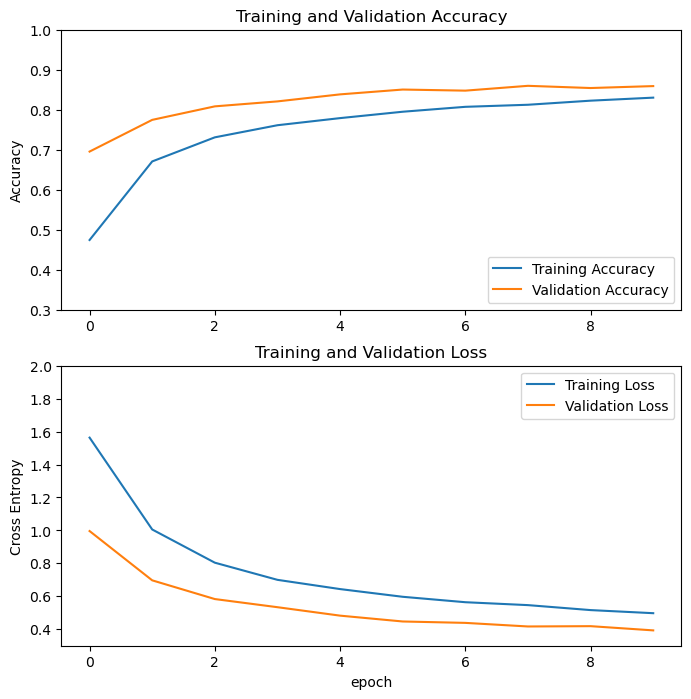

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0.3,1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0.3,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Unfreeeze Some Layers of Feature Extractor

In [28]:
base_model.trainable = True

print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


# Compile the Model

In [29]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [30]:
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_9 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 264)            │       338,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 264)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 264)            │        69,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 264)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        16,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,683,738 (10.24 MB)

 Trainable params: 2,287,194 (8.72 MB)

 Non-trainable params: 396,544 (1.51 MB)

# Add Callbacks

In [31]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

#  file extension to .keras
checkpoint = ModelCheckpoint('./mobileNetV2_NN.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
log_csv = CSVLogger('./mobileNetV2_NN_logs2.csv', separator=',', append=False)

callbacks_list = [checkpoint, early_stop, log_csv]



# Continue Model Training

In [32]:
fine_tune_epochs = 100
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                         callbacks=callbacks_list)

Epoch 10/110
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.6441 - loss: 1.1239
Epoch 10: val_loss improved from inf to 0.63734, saving model to ./mobileNetV2_NN.keras
273/273 ━━━━━━━━━━━━━━━━━━━━ 119s 428ms/step - accuracy: 0.6444 - loss: 1.1229 - val_accuracy: 0.7922 - val_loss: 0.6373
Epoch 11/110
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.7926 - loss: 0.6148
Epoch 11: val_loss did not improve from 0.63734
273/273 ━━━━━━━━━━━━━━━━━━━━ 117s 429ms/step - accuracy: 0.7926 - loss: 0.6147 - val_accuracy: 0.7850 - val_loss: 0.6585
Epoch 12/110
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.8241 - loss: 0.5092
Epoch 12: val_loss improved from 0.63734 to 0.58338, saving model to ./mobileNetV2_NN.keras
273/273 ━━━━━━━━━━━━━━━━━━━━ 118s 433ms/step - accuracy: 0.8241 - loss: 0.5091 - val_accuracy: 0.8081 - val_loss: 0.5834
Epoch 13/110
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.8447 - loss: 0.4401
Epoch 13: val_loss improved from 0.58338 to 0.482

In [33]:
model.save('mobileNetV2.keras')

# Plot Learning Curve 

In [34]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

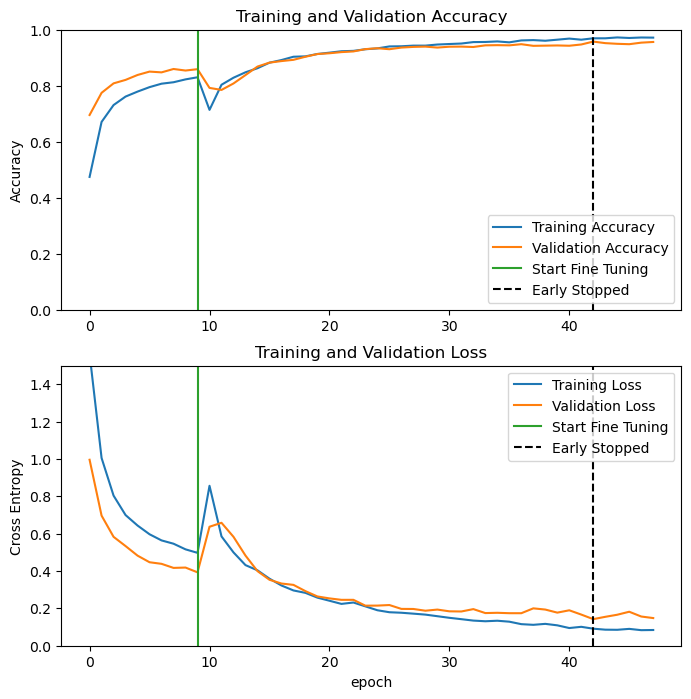

In [35]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.plot([len(acc)-6, len(acc)-6], plt.ylim(),
         label='Early Stopped', linestyle='--', color='black')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.5])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.plot([len(acc)-6, len(acc)-6], plt.ylim(),
         label='Early Stopped', linestyle='--', color='black')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.ylabel('Cross Entropy')
plt.show()

In [37]:
import os

os.chdir("/Users/krish/Thesis/data2")

CLASSES = []

folders = os.listdir(TESTING_DIR)
for f in folders:
    if f != '.DS_Store':  # Exclude .DS_Store file
        CLASSES.append(f)
        
CLASSES


['Late_blight',
 'Septoria_leaf_spot',
 'Tomato_Yellow_Leaf_Curl_Virus',
 'Healthy',
 'Early_blight',
 'Target_Spot',
 'Leaf_Mold',
 'Tomato_mosaic_virus',
 'Bacterial_spot',
 'Two_spotted_spider_mite']

# Prediction and Evaluation

In [38]:
predictions = np.array([])
labels =  np.array([])

for x, y in test_dataset:
    predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis = -1)])
    labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

2024-08-23 10:45:43.387266: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Evaluating the Algorithm

Accuracy: 		 0.9581331503088538
Precision: 		 0.9596983178854283
Recall: 		 0.9581331503088538
F1 score: 		 0.9581331503088538 



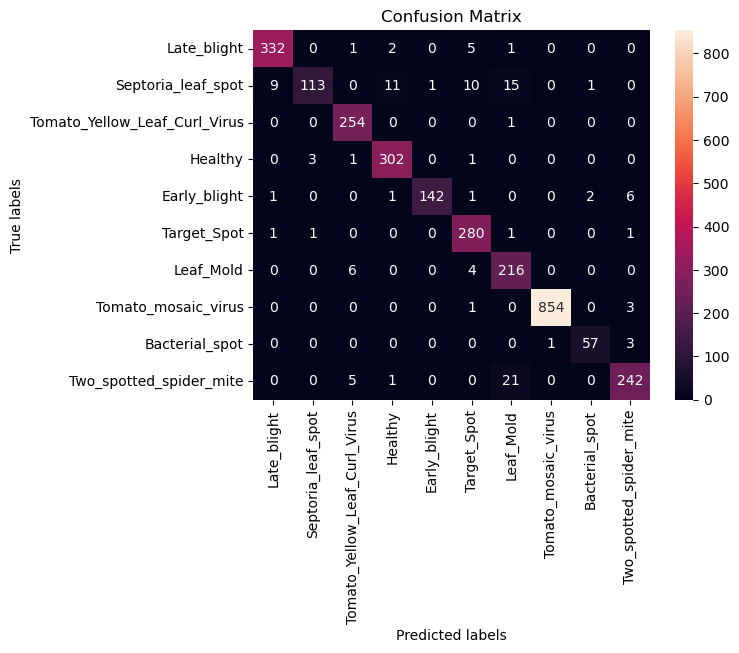

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming 'labels' and 'predictions' are your actual and predicted labels respectively

print('Evaluating the Algorithm\n')
print('Accuracy: \t\t', accuracy_score(labels, predictions))
print('Precision: \t\t', precision_score(labels, predictions, average='weighted'))
print('Recall: \t\t', recall_score(labels, predictions, average='weighted'))
print('F1 score: \t\t', f1_score(labels, predictions, average='micro'), '\n')

# Confusion Matrix
cf = tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()

# Plot Confusion Matrix
ax = plt.subplot()
sns.heatmap(cf, annot=True, fmt='g', ax=ax)

# Set titles and labels
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')

# Set tick labels based on the number of classes
num_classes = len(CLASSES)

if cf.shape[0] == num_classes:
    ax.xaxis.set_ticklabels(CLASSES)
    ax.yaxis.set_ticklabels(CLASSES)


plt.xticks(rotation=90)
plt.yticks(rotation=360)

plt.show()
